# LSTM on time series

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/lstm1.png" width="1200">



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

%matplotlib inline

<h3>Step #1. Read data</h3>

In [21]:
import pandas_datareader as data

symbol = 'AAPL'
data_source='google'
start_date = '2004-08-19'
end_date = '2022-11-10'
dataset_train = data.get_data_yahoo(symbol, start_date, end_date)
dataset_train = dataset_train.reset_index(level=['Date'])          # index to colum Date
dataset_train

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,0.568929,0.542143,0.562679,0.548393,388920000.0,0.467460
1,2004-08-20,0.553393,0.544464,0.548393,0.550000,316780800.0,0.468830
2,2004-08-23,0.558393,0.546429,0.551071,0.555000,254660000.0,0.473092
3,2004-08-24,0.570536,0.556964,0.558214,0.570536,374136000.0,0.486335
4,2004-08-25,0.591964,0.566607,0.569107,0.590179,505618400.0,0.503079
...,...,...,...,...,...,...,...
4586,2022-11-04,142.669998,134.380005,142.089996,138.380005,140716700.0,138.380005
4587,2022-11-07,139.149994,135.669998,137.110001,138.919998,83374600.0,138.919998
4588,2022-11-08,141.429993,137.490005,140.410004,139.500000,89908500.0,139.500000
4589,2022-11-09,138.550003,134.589996,138.500000,134.869995,74917800.0,134.869995


In [22]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4591 entries, 0 to 4590
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4591 non-null   datetime64[ns]
 1   High       4591 non-null   float64       
 2   Low        4591 non-null   float64       
 3   Open       4591 non-null   float64       
 4   Close      4591 non-null   float64       
 5   Volume     4591 non-null   float64       
 6   Adj Close  4591 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 251.2 KB


In [23]:
# # Importing Training Set
# dataset_train = pd.read_csv('GOOG.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4591, 7)
All timestamps == 4591
Featured selected: ['High', 'Low', 'Open', 'Close', 'Volume']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [24]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (4591, 5).


array([[5.68929017e-01, 5.42142987e-01, 5.62678993e-01, 5.48393011e-01,
        3.88920000e+08],
       [5.53393006e-01, 5.44463992e-01, 5.48393011e-01, 5.50000012e-01,
        3.16780800e+08],
       [5.58393002e-01, 5.46428978e-01, 5.51070988e-01, 5.55000007e-01,
        2.54660000e+08],
       ...,
       [1.41429993e+02, 1.37490005e+02, 1.40410004e+02, 1.39500000e+02,
        8.99085000e+07],
       [1.38550003e+02, 1.34589996e+02, 1.38500000e+02, 1.34869995e+02,
        7.49178000e+07],
       [1.46869995e+02, 1.39500000e+02, 1.41240005e+02, 1.46869995e+02,
        1.18854000e+08]])

In [25]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.8065736 ],
       [-0.80691772],
       [-0.80680697],
       ...,
       [ 2.31343849],
       [ 2.24964796],
       [ 2.43393221]])

In [26]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (4442, 90, 4).
y_train shape == (4442, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [27]:
# Import Libraries and packages from Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LeakyReLU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


In [28]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1),activation=LeakyReLU(alpha=0.2)))
# Adding 2nd LSTM layer
model.add(LSTM(units=64, return_sequences=True,activation=LeakyReLU(alpha=0.2)))
# Adding 3nd LSTM layer
model.add(LSTM(units=32, return_sequences=False,activation="relu"))
# Adding Dropout
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.0001), loss='mse')

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 90, 64)            17664     
                                                                 
 lstm_4 (LSTM)               (None, 90, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 63,137
Trainable params: 63,137
Non-trainable params: 0
_________________________________________________________________


<h3>Step #4. Start training</h3>

In [30]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, 
                    y_train, 
                    shuffle=True, 
                    epochs=5, 
                    callbacks=[es, rlr, mcp, tb], 
                    validation_split=0.2, 
                    verbose=1, 
                    batch_size=200)

Epoch 1/5
18/18 [==============================] - ETA: 0s - loss: 0.2896
Epoch 1: val_loss improved from inf to 4.07367, saving model to weights.h5
18/18 [==============================] - 10s 392ms/step - loss: 0.2896 - val_loss: 4.0737 - lr: 1.0000e-04
Epoch 2/5
18/18 [==============================] - ETA: 0s - loss: 0.2457
Epoch 2: val_loss improved from 4.07367 to 3.73807, saving model to weights.h5
18/18 [==============================] - 7s 412ms/step - loss: 0.2457 - val_loss: 3.7381 - lr: 1.0000e-04
Epoch 3/5
18/18 [==============================] - ETA: 0s - loss: 0.2112
Epoch 3: val_loss improved from 3.73807 to 3.30922, saving model to weights.h5
18/18 [==============================] - 7s 364ms/step - loss: 0.2112 - val_loss: 3.3092 - lr: 1.0000e-04
Epoch 4/5
18/18 [==============================] - ETA: 0s - loss: 0.1756
Epoch 4: val_loss improved from 3.30922 to 2.70933, saving model to weights.h5
18/18 [==============================] - 7s 364ms/step - loss: 0.1756 - v

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>


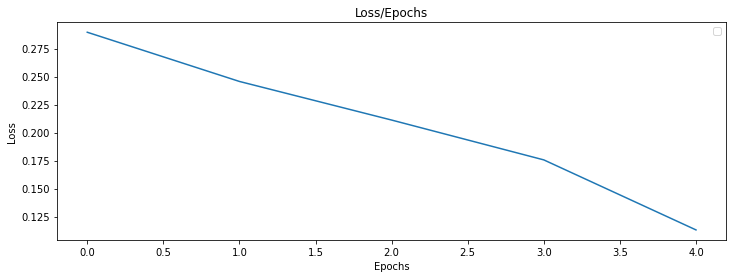

In [31]:
losses_lstm = history.history['loss']

plt.figure(figsize=(12,4))
plt.title('Loss/Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses_lstm)),losses_lstm)
plt.legend();

<h2>PART 3. Make future predictions</h2>

In [32]:
datelist_train[-1]

Timestamp('2022-11-10 00:00:00')

In [33]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [34]:
datelist_future_[-1] #60 days forward

datetime.date(2023, 1, 8)

<h3>Step #5. Make predictions for future dates</h3>

In [35]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

136/136 [==============================] - 4s 26ms/step


In [36]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2005-08-01,15.200285
2005-08-02,15.192430
2005-08-03,15.185167


<h3>Step #6. Visualize the Predictions</h3>

In [37]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

Text(0, 0.5, 'Stock Price Value')

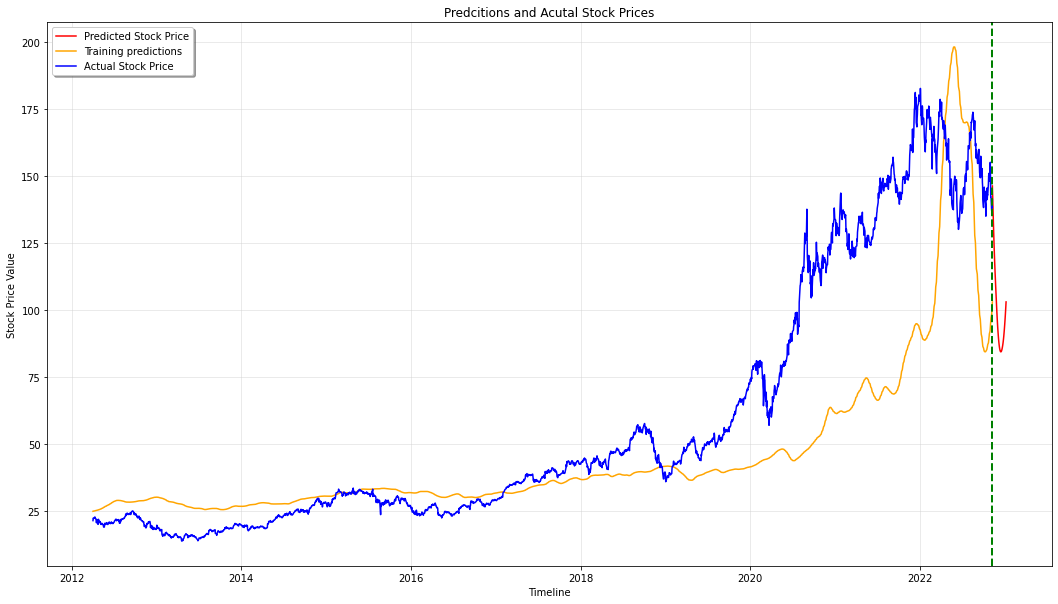

In [38]:
plt.figure(figsize=(18,10))
# Plot parameters
START_DATE_FOR_PLOTTING = '2012-04-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices',fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
#plt.xticks(rotation=45, fontsize=8)